In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import xgboost as xgb

In [3]:
xgb.__version__

'1.1.1'

In [4]:
DATA_DIR_PATH = os.path.join('..', '..', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [5]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
#df_train.head(3)

199


In [6]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])

WORD_CLASSE_LABELS = ['その他', 'フィラー', '副詞', '助動詞', '助詞',
                     '動詞', '名詞', '形容詞', '感動詞', '接続詞',
                     '接頭詞', '記号', '連体詞',]
new_wc_columns = {}
for (i, name) in enumerate(WORD_CLASSE_LABELS):
  new_wc_columns['wc_sum_{}'.format(name)] = 'wc_sum_{}'.format(i)
  new_wc_columns['wc_rate_{}'.format(name)] = 'wc_rate_{}'.format(i)


def data_preprocess(df):
  new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

  new_df['category'] = cat_le.transform(new_df['category'])

  new_df['rating'] = new_df['rating'] * 10
  new_df = new_df.astype({'rating': 'int32'})

  #wc_columns = [col for col in new_df.columns if col.find('wc_') != -1]
  #new_df = new_df.drop(wc_columns, axis=1)
  wc_columns = [col for col in new_df.columns if col.find('wc_sum_') != -1]
  new_df = new_df.drop(wc_columns, axis=1)
  new_df = new_df.rename(columns=new_wc_columns)

  kw_columns = [col for col in new_df.columns if col.find('kw_') != -1]
  new_df = new_df.drop(kw_columns, axis=1)

  return new_df

In [7]:
df_train.keys()

Index(['ncode', 'title', 'category', 'bookmark_cat', 'created_at',
       'updated_at', 'char_count_sum', 'new_line_count_sum',
       'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_sum_その他', 'wc_sum_フィラー', 'wc_sum_副詞',
       'wc_sum_助動詞', 'wc_sum_助詞', 'wc_sum_動詞', 'wc_sum_名詞', 'wc_sum_形容詞',
       'wc_sum_感動詞', 'wc_sum_接続詞', 'wc_sum_接頭詞', 'wc_sum_記号', 'wc_sum_連体詞',
       'wc_rate_その他', 'wc_rate_フィラー', 'wc_rate_副詞', 'wc_rate_助動詞',
       'wc_rate_助詞', 'wc_rate_動詞', 'wc_rate_名詞', 'wc_rate_形容詞', 'wc_rate_感動詞',
       'wc_rate_接続詞', 'wc_rate_接頭詞', 'wc_rate_記号', 'wc_rate_連体詞', 'kw_冒険者',
       'kw_魔王', 'kw_日常', 'kw_成り上がり', 'kw_内政', 'kw_恋愛', 'kw_無双', 'kw_青春',
       'kw_ハーレム', 'kw_男主人公', 'kw_奴隷', 'kw_テンプレ', 'kw_勘違い', 'kw_ほのぼの', 'kw_貴族',
       'kw_ギルド', 'kw_コメディ', 'kw_異世界', 'kw_エルフ', 'kw_ファンタジー', 'kw_オリジナル戦記',
       

In [8]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,...,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,0.041585,0.313515,3078.0,128.0,...,0.237664,0.226083,0.225076,0.013595,0.006042,0.007049,0.006042,0.144008,0.011078,30
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,0.053159,0.063559,2596.0,138.0,...,0.238590,0.238013,0.217215,0.017909,0.001155,0.010399,0.001155,0.138070,0.013287,40
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,0.051603,0.170842,1996.0,103.0,...,0.240486,0.177328,0.285020,0.014575,0.000000,0.005668,0.008907,0.148178,0.005668,30


In [9]:
X = df_train2.drop(['rating'], axis=1).values
y = df_train2['rating'].values
print(X.shape, y.shape)

(199, 26) (199,)


In [10]:
feature_names = df_train2.keys()[:-1]

In [11]:
print(feature_names)
print(len(feature_names))

Index(['category', 'created_at', 'updated_at', 'char_count_sum',
       'new_line_count_sum', 'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_rate_0', 'wc_rate_1', 'wc_rate_2',
       'wc_rate_3', 'wc_rate_4', 'wc_rate_5', 'wc_rate_6', 'wc_rate_7',
       'wc_rate_8', 'wc_rate_9', 'wc_rate_10', 'wc_rate_11', 'wc_rate_12'],
      dtype='object')
26


In [12]:
# print(y)

# u, counts = np.unique(y, return_counts=True)
# print(len(u))
# print(u)
# print(counts)

In [13]:
from imblearn.over_sampling import RandomOverSampler

In [14]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

u, counts = np.unique(y_resampled, return_counts=True)
print(len(u))
print(u)
print(counts)

(915, 26) (915,)
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[61 61 61 61 61 61 61 61 61 61 61 61 61 61 61]


In [15]:
from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=1)

In [16]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(640, 26) (640,)
(275, 26) (275,)


In [17]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

In [18]:
print(dtrain.feature_names)

['category', 'created_at', 'updated_at', 'char_count_sum', 'new_line_count_sum', 'talk_char_count_sum', 'new_line_count_rate_sum', 'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg', 'talk_char_count_avg', 'new_line_count_rate_avg', 'talk_char_count_rate_avg', 'wc_rate_0', 'wc_rate_1', 'wc_rate_2', 'wc_rate_3', 'wc_rate_4', 'wc_rate_5', 'wc_rate_6', 'wc_rate_7', 'wc_rate_8', 'wc_rate_9', 'wc_rate_10', 'wc_rate_11', 'wc_rate_12']


In [19]:
xgb_params = {
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=20,
                evals=evals,
                evals_result=evals_result)

[13:10:09] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:29.48635	eval-rmse:31.14042
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:21.48445	eval-rmse:23.02701
[2]	train-rmse:15.68184	eval-rmse:17.22133
[3]	train-rmse:11.69560	eval-rmse:13.52017
[4]	train-rmse:8.65907	eval-rmse:10.80927
[5]	train-rmse:6.65944	eval-rmse:9.16982
[6]	train-rmse:5.10162	eval-rmse:8.12059
[7]	train-rmse:4.14760	eval-rmse:7.51638
[8]	train-rmse:3.54806	eval-rmse:7.19288
[9]	train-rmse:2.92686	eval-rmse:6.89970
[10]	train-rmse:2.63887	eval-rmse:6.72240
[11]	train-rmse:2.26690	eval-rmse:6.54652
[12]	train-rmse:2.10129	eval-rmse:6.47745
[13]	train-rmse:1.94550	eval-rmse:6.43304
[14]	train-rmse:1.80101	eval-rmse:6.39302
[15]	train-rmse:1.57171	eval-rmse:6.34307
[16]	train-rmse:1.48311	eval-rmse:6.3

In [20]:
import math
from sklearn.metrics import mean_squared_error

y_pred = bst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 6.005429110600139


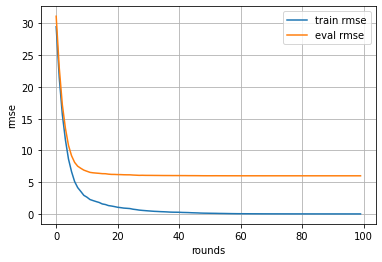

In [21]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

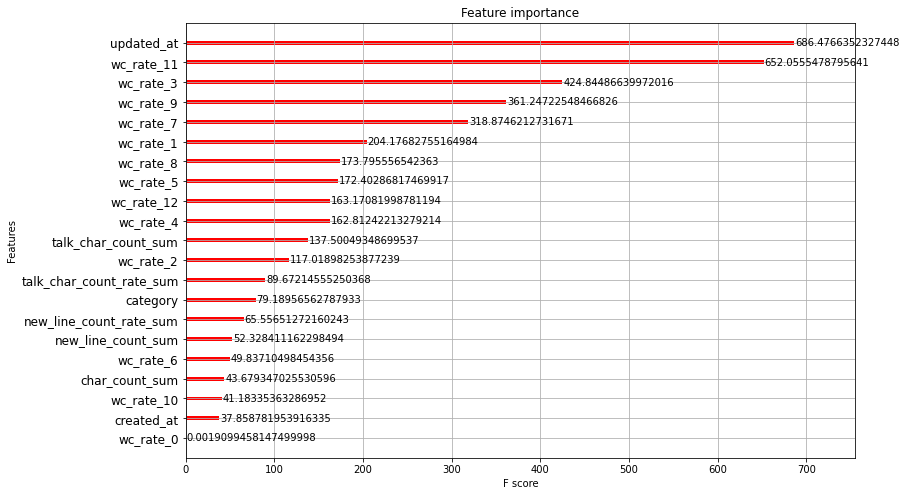

In [39]:
_, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(bst,ax=ax,
                    importance_type='gain',
                    show_values=True,
                    color='red')

plt.yticks(fontsize=12)
#plt.figure(dpi=80)

plt.show()

In [23]:
#xgb.to_graphviz(bst, num_trees=1)

In [24]:
df_test = laod_data('ranking_test_data.csv')
print(len(df_test))
#df_test.head(3)

65


In [25]:
df_test2 = data_preprocess(df_test)
df_test2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,...,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.585469e+09,1.593763e+09,37740,2310,0,0.061208,0.000000,1258.0,77.0,...,0.240634,0.149856,0.386167,0.014409,0.000000,0.000000,0.000000,0.171470,0.001441,-10
1,6,1.591009e+09,1.593774e+09,144330,5760,44100,0.039909,0.305550,4811.0,192.0,...,0.252519,0.217420,0.238219,0.019175,0.002600,0.006175,0.000975,0.132272,0.008450,-10
2,6,1.587737e+09,1.593006e+09,156720,6210,13290,0.039625,0.084801,5224.0,207.0,...,0.248532,0.211128,0.241731,0.011437,0.002473,0.007419,0.001546,0.126739,0.012056,-10


In [26]:
X = df_test2.drop(['rating'], axis=1).values
y = df_test2['rating'].values
print(X.shape)

#dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X, label=y, feature_names=feature_names)
#print(dtest)

(65, 26)


In [28]:
y_pred = bst.predict(dtest)
#y_pred

In [29]:
df_rating = pd.DataFrame(columns=['ncode', 'title', 'rating'])

for i, y in enumerate(y_pred):
    row = df_test.loc[i] 
    #print('{}\t{}\t{}'.format(row.ncode, row.title, y))
    df_rating = df_rating.append({'ncode': row.ncode, 'title': row.title, 'rating': y}, ignore_index=True)

In [31]:
#df_rating.head()

In [32]:
df_rating.describe()

,rating
count,65.000000
mean,24.588104
std,7.529778
min,11.145062
25%,18.921967
50%,24.137463
75%,28.626982
max,44.654007


In [33]:
df_rating.var()

rating    56.697557
dtype: float64

In [34]:
df_rating.median()

rating    24.137463
dtype: float64

In [35]:
pd.set_option('display.max_rows', None)

df_rating.sort_values('rating', ascending=False)

,ncode,title,rating
60,n5645ci,自分が異世界に転移するなら,44.654007
61,n4344dy,世界最強の後衛 ～迷宮国の新人探索者～,41.295052
4,n6812gh,悪徳領主の息子に転生！？ ～普通に行動しているだけなのに、周囲からちやほやされます～,40.364941
38,n3742ey,ご主人様とゆく異世界サバイバル！,38.883430
44,n9984fb,身体は児童、中身はおっさんの成り上がり冒険記,37.171757
49,n1234gg,魔法戦士セイクリッド・ナイツ～エロゲの触手怪人に転生した俺は、変身ヒロインたちを守り抜く～,36.045532
23,n9629ex,最弱テイマーはゴミ拾いの旅を始めました。,35.840317
41,n6078fg,不死鳥への転生 ドラゴン倒せるって普通の鳥じゃないよね？ （旧題：憧れへの転生 以下同文）,34.564163
63,n6078gg,イントゥ・ザ・ゴーレム！～土くれに生まれ変わった私は自己改造で進化する～,34.067009
13,n5677cl,亡びの国の征服者～魔王は世界を征服するようです～,31.989611
